In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import math

from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import cv2 as cv
from PIL import Image

import multiprocessing
from multiprocessing.pool import ThreadPool

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelBinarizer

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import cv2



Using TensorFlow backend.


In [2]:
data = np.load("all/train_images.npy",encoding='bytes')

x = []
for image in data:
    image = image[1].reshape(100,100)
    x.append(image)

x_pre = []
for image in data:
    image = image[1].reshape(100,100)
    x_pre.append(image)



labels = pd.read_csv("all/train_labels.csv")
y = []
for i in range(len(labels)):
    label = labels['Category'][i]
    y.append(label)


x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size = 0.1, random_state=30)

x_train_backup = x_train
x_validation_backup = x_validation

x_train = np.array(x_train).reshape(len(x_train), 100, 100, 1).astype('float32') / 255
x_validation = np.array(x_validation).reshape(len(x_validation), 100, 100, 1).astype('float32') / 255

encoder = LabelBinarizer()

y_train = encoder.fit_transform(y_train)
y_validation = encoder.fit_transform(y_validation)

y_train_decoded = encoder.inverse_transform(y_train)
y_validation_decoded = encoder.inverse_transform(y_train)


##Setup CNN
model = Sequential()
model.add(Conv2D(filters=20,
                 kernel_size=(4, 4),
                 padding='same',
                 input_shape=(100, 100, 1),
                 activation='relu'))
model.add(Conv2D(filters=20,
                 kernel_size=(4, 4),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(filters=80,
                 kernel_size=(4, 4),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(units=512))
model.add(BatchNormalization())
model.add(Dense(units=256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(31, activation='softmax'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #adam

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

##Fit CNN model
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)




learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)




batch_size = 32
epochs = 37

train_history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    epochs=epochs, validation_data=(x_validation, y_validation),
                                    verbose=2, steps_per_epoch=x_train.shape[0] // batch_size
                                    , callbacks=[learning_rate_reduction])

data_test = np.load("all/test_images.npy",encoding='bytes')

x_test = []
for image in data_test:
    image = image[1].reshape(100,100)
    x_test.append(image)

x_test = np.array(x_test).reshape(len(x_test), 100, 100, 1).astype('float32') / 255

prediction = model.predict_classes(x_test)
df = pd.DataFrame(prediction)
df.index += 1
df.index.name = 'Id'
df.columns = ['Category']
df.to_csv('cnn.csv', header=True)

word_class = []
for i in range(len(df)):
    c = encoder.classes_[df['Category'][i+1]]
    word_class.append(c)

word_class = np.array(word_class)
word_class = pd.DataFrame(word_class)
word_class.columns = ['Category']
word_class.to_csv('cnn.csv', header=True)


Using TensorFlow backend.


Epoch 1/37
 - 10s - loss: 2.6068 - acc: 0.2649 - val_loss: 1.7400 - val_acc: 0.4980
Epoch 2/37
 - 9s - loss: 1.7892 - acc: 0.4958 - val_loss: 1.2604 - val_acc: 0.6520
Epoch 3/37
 - 8s - loss: 1.4891 - acc: 0.5797 - val_loss: 1.1972 - val_acc: 0.6700
Epoch 4/37
 - 9s - loss: 1.2900 - acc: 0.6372 - val_loss: 1.0207 - val_acc: 0.7060
Epoch 5/37
 - 8s - loss: 1.1694 - acc: 0.6628 - val_loss: 0.9669 - val_acc: 0.7120
Epoch 6/37
 - 8s - loss: 1.0708 - acc: 0.6919 - val_loss: 0.8989 - val_acc: 0.7450
Epoch 7/37
 - 8s - loss: 0.9914 - acc: 0.7172 - val_loss: 0.9476 - val_acc: 0.7430
Epoch 8/37
 - 9s - loss: 0.9627 - acc: 0.7247 - val_loss: 0.8475 - val_acc: 0.7600
Epoch 9/37
 - 9s - loss: 0.9110 - acc: 0.7420 - val_loss: 0.8154 - val_acc: 0.7680
Epoch 10/37
 - 9s - loss: 0.8415 - acc: 0.7561 - val_loss: 0.8116 - val_acc: 0.7820
Epoch 11/37
 - 8s - loss: 0.8024 - acc: 0.7634 - val_loss: 0.7593 - val_acc: 0.7860
Epoch 12/37
 - 9s - loss: 0.7781 - acc: 0.7720 - val_loss: 0.8012 - val_acc: 0.7800


C:\Users\Eric Vuong\Anaconda3\envs\tensorflowgpu\lib\site-packages\matplotlib\axes\_base.py:3122: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


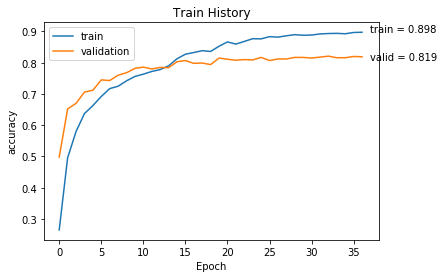

In [3]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
epoch_num = len(history.epoch)
final_epoch_train_acc = history.history['acc'][epoch_num - 1]
final_epoch_validation_acc = history.history['val_acc'][epoch_num - 1]
plt.text(epoch_num, final_epoch_train_acc, 'train = {:.3f}'.format(final_epoch_train_acc))
plt.text(epoch_num, final_epoch_validation_acc-0.01, 'valid = {:.3f}'.format(final_epoch_validation_acc))
plt.title('Train History')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.xlim(xmax=epoch_num+1)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [5]:
data = np.load("all/train_images.npy",encoding='bytes')

x = []
for image in data:
    image = image[1].reshape(100,100)
    x.append(image)

x_pre = []
for image in data:
    image = image[1].reshape(100,100)
    image = preprocess(image)
    image = preProcessImage(image)
    image = rmEmpty(image)
    x_pre.append(image)



labels = pd.read_csv("all/train_labels.csv")
y = []
for i in range(len(labels)):
    label = labels['Category'][i]
    y.append(label)


x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size = 0.1, random_state=30)

x_train_backup = x_train
x_validation_backup = x_validation

x_train = np.array(x_train).reshape(len(x_train), 100, 100, 1).astype('float32') / 255
x_validation = np.array(x_validation).reshape(len(x_validation), 100, 100, 1).astype('float32') / 255

encoder = LabelBinarizer()

y_train = encoder.fit_transform(y_train)
y_validation = encoder.fit_transform(y_validation)

y_train_decoded = encoder.inverse_transform(y_train)
y_validation_decoded = encoder.inverse_transform(y_train)


##Setup CNN
model = Sequential()
model.add(Conv2D(filters=20,
                 kernel_size=(4, 4),
                 padding='same',
                 input_shape=(100, 100, 1),
                 activation='relu'))
model.add(Conv2D(filters=20,
                 kernel_size=(4, 4),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(filters=80,
                 kernel_size=(4, 4),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(units=512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(units=256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(31, activation='softmax'))


optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #adam

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

##Fit CNN model
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)




learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)




batch_size = 32
epochs = 37

train_history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    epochs=epochs, validation_data=(x_validation, y_validation),
                                    verbose=2, steps_per_epoch=x_train.shape[0] // batch_size
                                    , callbacks=[learning_rate_reduction])

data_test = np.load("all/test_images.npy",encoding='bytes')

x_test = []
for image in data_test:
    image = image[1].reshape(100,100)
    image = preprocess(image)
    image = preProcessImage(image)
    image = rmEmpty(image)
    x_test.append(image)

x_test = np.array(x_test).reshape(len(x_test), 100, 100, 1).astype('float32') / 255

prediction = model.predict_classes(x_test)
df = pd.DataFrame(prediction)
df.index += 1
df.index.name = 'Id'
df.columns = ['Category']
df.to_csv('cnn.csv', header=True)

word_class = []
for i in range(len(df)):
    c = encoder.classes_[df['Category'][i+1]]
    word_class.append(c)

word_class = np.array(word_class)
word_class = pd.DataFrame(word_class)
word_class.columns = ['Category']
word_class.to_csv('cnn.csv', header=True)


Epoch 1/37
 - 8s - loss: 3.7875 - acc: 0.0579 - val_loss: 6.7417 - val_acc: 0.0420
Epoch 2/37
 - 6s - loss: 3.3190 - acc: 0.0884 - val_loss: 3.5017 - val_acc: 0.0700
Epoch 3/37
 - 6s - loss: 3.2008 - acc: 0.0911 - val_loss: 3.0078 - val_acc: 0.1190
Epoch 4/37
 - 6s - loss: 2.8543 - acc: 0.1665 - val_loss: 2.7239 - val_acc: 0.2020
Epoch 5/37
 - 6s - loss: 2.4871 - acc: 0.2665 - val_loss: 2.2990 - val_acc: 0.3210
Epoch 6/37
 - 6s - loss: 2.1489 - acc: 0.3653 - val_loss: 2.0280 - val_acc: 0.3920
Epoch 7/37
 - 6s - loss: 1.9243 - acc: 0.4364 - val_loss: 1.8474 - val_acc: 0.4570
Epoch 8/37
 - 6s - loss: 1.7793 - acc: 0.4820 - val_loss: 1.6697 - val_acc: 0.5170
Epoch 9/37
 - 7s - loss: 1.6640 - acc: 0.5191 - val_loss: 1.5765 - val_acc: 0.5290
Epoch 10/37
 - 7s - loss: 1.5527 - acc: 0.5520 - val_loss: 1.5412 - val_acc: 0.5750
Epoch 11/37
 - 6s - loss: 1.4740 - acc: 0.5741 - val_loss: 1.4686 - val_acc: 0.5800
Epoch 12/37
 - 6s - loss: 1.3584 - acc: 0.6065 - val_loss: 1.3831 - val_acc: 0.6210
E

In [4]:
def preprocess(image, cutoff=127, maxContours=5):
    image = np.uint8(image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image,connectivity = 4)
    sizes = stats[:,-1]
    max_label = 1
    max_size = sizes[1]
    for i in range(2,nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
    img = np.zeros(output.shape)
    img[output == max_label] = 255
    return img

def preProcessImage(image, cutoff=127, maxContours=10):
    image = np.uint8(image)
    im = np.uint8(image)
    red, thresh = cv2.threshold(im, cutoff, 255, 0)
    im2, contours, hierarchy= cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(im.shape, np.uint8)
    largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for ind, contour in enumerate(largest_contours[:5]):
        x, y, w, h = cv2.boundingRect(contour)
        mask[y:y+h, x:x+w] = 255    
    filteredImage = cv2.bitwise_and(thresh, thresh, mask=mask)
    return filteredImage.reshape((image.shape))

def rmEmpty(img):
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
    sizes = stats[1:, -1]; nb_components = nb_components - 1
    min_size = 50
    img2 = np.zeros((output.shape))
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            img2[output == i + 1] = 255
    return img2

In [6]:
data = np.load("all/train_images.npy",encoding='bytes')

x = []
for image in data:
    image = image[1].reshape(100,100)
    x.append(image)

x_pre = []
for image in data:
    image = image[1].reshape(100,100)
#     image = preprocess(image)
#     image = preProcessImage(image)
#     image = rmEmpty(image)
    x_pre.append(image)



labels = pd.read_csv("all/train_labels.csv")
y = []
for i in range(len(labels)):
    label = labels['Category'][i]
    y.append(label)


x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size = 0.1, random_state=30)

x_train_backup = x_train
x_validation_backup = x_validation

x_train = np.array(x_train).reshape(len(x_train), 100, 100, 1).astype('float32') / 255
x_validation = np.array(x_validation).reshape(len(x_validation), 100, 100, 1).astype('float32') / 255

encoder = LabelBinarizer()

y_train = encoder.fit_transform(y_train)
y_validation = encoder.fit_transform(y_validation)

y_train_decoded = encoder.inverse_transform(y_train)
y_validation_decoded = encoder.inverse_transform(y_train)


##Setup CNN
model = Sequential()
model.add(Conv2D(filters=20,
                 kernel_size=(4, 4),
                 padding='same',
                 input_shape=(100, 100, 1),
                 activation='relu'))
model.add(Conv2D(filters=20,
                 kernel_size=(4, 4),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(filters=80,
                 kernel_size=(4, 4),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(units=512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(units=256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(31, activation='softmax'))


optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #adam

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

##Fit CNN model
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)




learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)




batch_size = 32
epochs = 37

train_history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    epochs=epochs, validation_data=(x_validation, y_validation),
                                    verbose=2, steps_per_epoch=x_train.shape[0] // batch_size
                                    , callbacks=[learning_rate_reduction])

data_test = np.load("all/test_images.npy",encoding='bytes')

x_test = []
for image in data_test:
    image = image[1].reshape(100,100)
#     image = preprocess(image)
#     image = preProcessImage(image)
#     image = rmEmpty(image)
    x_test.append(image)

x_test = np.array(x_test).reshape(len(x_test), 100, 100, 1).astype('float32') / 255

prediction = model.predict_classes(x_test)
df = pd.DataFrame(prediction)
df.index += 1
df.index.name = 'Id'
df.columns = ['Category']
df.to_csv('cnn.csv', header=True)

word_class = []
for i in range(len(df)):
    c = encoder.classes_[df['Category'][i+1]]
    word_class.append(c)

word_class = np.array(word_class)
word_class = pd.DataFrame(word_class)
word_class.columns = ['Category']
word_class.to_csv('cnn.csv', header=True)


Epoch 1/37
 - 8s - loss: 3.8259 - acc: 0.0555 - val_loss: 5.2294 - val_acc: 0.0500
Epoch 2/37
 - 6s - loss: 3.3271 - acc: 0.0817 - val_loss: 3.6531 - val_acc: 0.0570
Epoch 3/37
 - 6s - loss: 3.2067 - acc: 0.0942 - val_loss: 4.8093 - val_acc: 0.0540
Epoch 4/37
 - 6s - loss: 3.0712 - acc: 0.1183 - val_loss: 3.3514 - val_acc: 0.1050
Epoch 5/37
 - 6s - loss: 2.6790 - acc: 0.2046 - val_loss: 2.8103 - val_acc: 0.1680
Epoch 6/37
 - 6s - loss: 2.3592 - acc: 0.2979 - val_loss: 2.1622 - val_acc: 0.3490
Epoch 7/37
 - 6s - loss: 2.0736 - acc: 0.3848 - val_loss: 2.0721 - val_acc: 0.3800
Epoch 8/37
 - 6s - loss: 1.8793 - acc: 0.4422 - val_loss: 1.7874 - val_acc: 0.4670
Epoch 9/37
 - 7s - loss: 1.6925 - acc: 0.4959 - val_loss: 1.6909 - val_acc: 0.4850
Epoch 10/37
 - 8s - loss: 1.5690 - acc: 0.5455 - val_loss: 1.4933 - val_acc: 0.5500
Epoch 11/37
 - 6s - loss: 1.4770 - acc: 0.5674 - val_loss: 1.4112 - val_acc: 0.5880
Epoch 12/37
 - 6s - loss: 1.3809 - acc: 0.5990 - val_loss: 1.3895 - val_acc: 0.6070
E

In [9]:
data = np.load("all/train_images.npy",encoding='bytes')

x = []
for image in data:
    image = image[1].reshape(100,100)
    x.append(image)

x_pre = []
for image in data:
    image = image[1].reshape(100,100)
#     image = preprocess(image)
#     image = preProcessImage(image)
#     image = rmEmpty(image)
    x_pre.append(image)



labels = pd.read_csv("all/train_labels.csv")
y = []
for i in range(len(labels)):
    label = labels['Category'][i]
    y.append(label)


x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size = 0.1, random_state=30)

x_train_backup = x_train
x_validation_backup = x_validation

x_train = np.array(x_train).reshape(len(x_train), 100, 100, 1).astype('float32') / 255
x_validation = np.array(x_validation).reshape(len(x_validation), 100, 100, 1).astype('float32') / 255

encoder = LabelBinarizer()

y_train = encoder.fit_transform(y_train)
y_validation = encoder.fit_transform(y_validation)

y_train_decoded = encoder.inverse_transform(y_train)
y_validation_decoded = encoder.inverse_transform(y_train)


##Setup CNN
model = Sequential()
model.add(Conv2D(filters=20,
                 kernel_size=(4, 4),
                 padding='same',
                 input_shape=(100, 100, 1),
                 activation='relu'))
model.add(Conv2D(filters=20,
                 kernel_size=(4, 4),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(filters=80,
                 kernel_size=(4, 4),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(units=512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(units=256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(31, activation='softmax'))


optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #adam

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

##Fit CNN model
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)




learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)




batch_size = 40
epochs = 15

train_history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    epochs=epochs, validation_data=(x_validation, y_validation),
                                    verbose=2, steps_per_epoch=x_train.shape[0] // batch_size
                                    , callbacks=[learning_rate_reduction])

data_test = np.load("all/test_images.npy",encoding='bytes')

x_test = []
for image in data_test:
    image = image[1].reshape(100,100)
#     image = preprocess(image)
#     image = preProcessImage(image)
#     image = rmEmpty(image)
    x_test.append(image)

x_test = np.array(x_test).reshape(len(x_test), 100, 100, 1).astype('float32') / 255

prediction = model.predict_classes(x_test)
df = pd.DataFrame(prediction)
df.index += 1
df.index.name = 'Id'
df.columns = ['Category']
df.to_csv('cnn.csv', header=True)

word_class = []
for i in range(len(df)):
    c = encoder.classes_[df['Category'][i+1]]
    word_class.append(c)

word_class = np.array(word_class)
word_class = pd.DataFrame(word_class)
word_class.columns = ['Category']
word_class.to_csv('cnn.csv', header=True)


Epoch 1/15
 - 7s - loss: 3.8427 - acc: 0.0557 - val_loss: 5.5204 - val_acc: 0.0440
Epoch 2/15
 - 6s - loss: 3.3264 - acc: 0.0830 - val_loss: 3.4085 - val_acc: 0.0850
Epoch 3/15
 - 6s - loss: 3.2062 - acc: 0.0968 - val_loss: 3.2053 - val_acc: 0.0990
Epoch 4/15
 - 6s - loss: 2.9120 - acc: 0.1642 - val_loss: 2.6212 - val_acc: 0.2330
Epoch 5/15
 - 6s - loss: 2.5344 - acc: 0.2477 - val_loss: 2.6262 - val_acc: 0.2360
Epoch 6/15
 - 6s - loss: 2.2538 - acc: 0.3198 - val_loss: 2.4727 - val_acc: 0.2960
Epoch 7/15
 - 6s - loss: 2.0462 - acc: 0.3901 - val_loss: 2.2860 - val_acc: 0.3570
Epoch 8/15
 - 6s - loss: 1.8388 - acc: 0.4529 - val_loss: 1.8078 - val_acc: 0.4680
Epoch 9/15
 - 6s - loss: 1.7047 - acc: 0.5028 - val_loss: 1.6772 - val_acc: 0.5050
Epoch 10/15
 - 6s - loss: 1.5478 - acc: 0.5503 - val_loss: 1.6751 - val_acc: 0.5100
Epoch 11/15
 - 6s - loss: 1.4533 - acc: 0.5760 - val_loss: 1.5045 - val_acc: 0.5740
Epoch 12/15
 - 6s - loss: 1.3487 - acc: 0.6157 - val_loss: 1.3379 - val_acc: 0.6160
E

In [11]:
data = np.load("all/train_images.npy",encoding='bytes')

x = []
for image in data:
    image = image[1].reshape(100,100)
    x.append(image)

x_pre = []
for image in data:
    image = image[1].reshape(100,100)
#     image = preprocess(image)
#     image = preProcessImage(image)
#     image = rmEmpty(image)
    x_pre.append(image)



labels = pd.read_csv("all/train_labels.csv")
y = []
for i in range(len(labels)):
    label = labels['Category'][i]
    y.append(label)


x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size = 0.1, random_state=30)

x_train_backup = x_train
x_validation_backup = x_validation

x_train = np.array(x_train).reshape(len(x_train), 100, 100, 1).astype('float32') / 255
x_validation = np.array(x_validation).reshape(len(x_validation), 100, 100, 1).astype('float32') / 255

encoder = LabelBinarizer()

y_train = encoder.fit_transform(y_train)
y_validation = encoder.fit_transform(y_validation)

y_train_decoded = encoder.inverse_transform(y_train)
y_validation_decoded = encoder.inverse_transform(y_train)


##Setup CNN
model = Sequential()
model.add(Conv2D(filters=20,
                 kernel_size=(4, 4),
                 padding='same',
                 input_shape=(100, 100, 1),
                 activation='relu'))
model.add(Conv2D(filters=20,
                 kernel_size=(4, 4),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(filters=80,
                 kernel_size=(4, 4),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=40,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units=512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(units=256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(31, activation='softmax'))


optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #adam

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

##Fit CNN model
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)




learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)




batch_size = 30
epochs = 30

train_history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    epochs=epochs, validation_data=(x_validation, y_validation),
                                    verbose=2, steps_per_epoch=x_train.shape[0] // batch_size
                                    , callbacks=[learning_rate_reduction])

data_test = np.load("all/test_images.npy",encoding='bytes')

x_test = []
for image in data_test:
    image = image[1].reshape(100,100)
#     image = preprocess(image)
#     image = preProcessImage(image)
#     image = rmEmpty(image)
    x_test.append(image)

x_test = np.array(x_test).reshape(len(x_test), 100, 100, 1).astype('float32') / 255

prediction = model.predict_classes(x_test)
df = pd.DataFrame(prediction)
df.index += 1
df.index.name = 'Id'
df.columns = ['Category']
df.to_csv('cnn.csv', header=True)

word_class = []
for i in range(len(df)):
    c = encoder.classes_[df['Category'][i+1]]
    word_class.append(c)

word_class = np.array(word_class)
word_class = pd.DataFrame(word_class)
word_class.columns = ['Category']
word_class.to_csv('cnn.csv', header=True)


Epoch 1/30
 - 8s - loss: 3.9393 - acc: 0.0421 - val_loss: 4.1351 - val_acc: 0.0350
Epoch 2/30
 - 6s - loss: 3.4323 - acc: 0.0742 - val_loss: 3.2709 - val_acc: 0.0660
Epoch 3/30
 - 6s - loss: 3.2665 - acc: 0.0887 - val_loss: 3.0933 - val_acc: 0.1010
Epoch 4/30
 - 6s - loss: 3.1635 - acc: 0.0967 - val_loss: 3.0031 - val_acc: 0.1340
Epoch 5/30
 - 6s - loss: 3.0689 - acc: 0.1141 - val_loss: 2.9350 - val_acc: 0.1220
Epoch 6/30
 - 6s - loss: 3.0005 - acc: 0.1213 - val_loss: 2.9752 - val_acc: 0.1410
Epoch 7/30
 - 6s - loss: 2.9103 - acc: 0.1456 - val_loss: 2.8058 - val_acc: 0.1640
Epoch 8/30
 - 6s - loss: 2.6639 - acc: 0.2079 - val_loss: 2.7196 - val_acc: 0.1790
Epoch 9/30
 - 6s - loss: 2.4740 - acc: 0.2614 - val_loss: 2.2975 - val_acc: 0.3070
Epoch 10/30
 - 6s - loss: 2.3184 - acc: 0.3019 - val_loss: 2.1525 - val_acc: 0.3660
Epoch 11/30
 - 6s - loss: 2.1642 - acc: 0.3556 - val_loss: 2.1129 - val_acc: 0.3450
Epoch 12/30
 - 6s - loss: 2.0267 - acc: 0.3814 - val_loss: 1.9331 - val_acc: 0.4030
E

In [ ]:
data = np.load("all/train_images.npy",encoding='bytes')

x = []
for image in data:
    image = image[1].reshape(100,100)
    x.append(image)

x_pre = []
for image in data:
    image = image[1].reshape(100,100)
    x_pre.append(image)



labels = pd.read_csv("all/train_labels.csv")
y = []
for i in range(len(labels)):
    label = labels['Category'][i]
    y.append(label)


x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size = 0.1, random_state=30)

x_train_backup = x_train
x_validation_backup = x_validation

x_train = np.array(x_train).reshape(len(x_train), 100, 100, 1).astype('float32') / 255
x_validation = np.array(x_validation).reshape(len(x_validation), 100, 100, 1).astype('float32') / 255

encoder = LabelBinarizer()

y_train = encoder.fit_transform(y_train)
y_validation = encoder.fit_transform(y_validation)

y_train_decoded = encoder.inverse_transform(y_train)
y_validation_decoded = encoder.inverse_transform(y_train)


##Setup CNN
model = Sequential()
model.add(Conv2D(filters=20,
                 kernel_size=(4, 4),
                 padding='same',
                 input_shape=(100, 100, 1),
                 activation='relu'))
model.add(Conv2D(filters=20,
                 kernel_size=(4, 4),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(filters=80,
                 kernel_size=(4, 4),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(units=512))
model.add(BatchNormalization())
model.add(Dense(units=256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(31, activation='softmax'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #adam

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

##Fit CNN model
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)




learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)




batch_size = 32
epochs = 37

train_history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    epochs=epochs, validation_data=(x_validation, y_validation),
                                    verbose=2, steps_per_epoch=x_train.shape[0] // batch_size
                                    , callbacks=[learning_rate_reduction])

data_test = np.load("all/test_images.npy",encoding='bytes')

x_test = []
for image in data_test:
    image = image[1].reshape(100,100)
    x_test.append(image)

x_test = np.array(x_test).reshape(len(x_test), 100, 100, 1).astype('float32') / 255

prediction = model.predict_classes(x_test)
df = pd.DataFrame(prediction)
df.index += 1
df.index.name = 'Id'
df.columns = ['Category']
df.to_csv('cnn.csv', header=True)

word_class = []
for i in range(len(df)):
    c = encoder.classes_[df['Category'][i+1]]
    word_class.append(c)

word_class = np.array(word_class)
word_class = pd.DataFrame(word_class)
word_class.columns = ['Category']
word_class.to_csv('cnn.csv', header=True)
